## **A Python Implementation of Sessa Empirical Estimator**  
### *By Jyreneah Angel and Nicole Grace Joligon*
---

### **Abstract**
The Sessa Empirical Estimator (SEE) is a method designed to estimate the duration of medication intervals by analyzing the temporal gaps between consecutive medication fills. This assignment implements SEE using Python, focusing on comparing two clustering approaches: *K-Means* and *DBSCAN*. The study utilizes a simulated dataset to demonstrate the SEE methodology and compares the results generated by the two clustering techniques. The objective is to analyze temporal intervals, filter out long gaps, standardize intervals, and perform clustering to generate insights. The comparison of K-Means and DBSCAN will highlight the strengths and weaknesses of both approaches in estimating medication intervals, providing a comprehensive understanding of their application in the SEE framework.

### **Introduction**

Medication adherence is a crucial factor in healthcare, as consistent and timely medication use significantly impacts treatment outcomes. Gaps between medication fills often serve as a key indicator of potential non-adherence, which can hinder the effectiveness of prescribed treatments. To assess medication intervals more accurately, the **Sessa Empirical Estimator (SEE)** methodology is employed. SEE focuses on identifying patterns in temporal gaps between consecutive medication fills, using clustering techniques to better understand medication regimens and patient compliance.

This study aims to implement the SEE method in Python and apply two clustering algorithms—**K-Means** and **DBSCAN**—to analyze temporal gaps within a simulated dataset of medication events. By applying these algorithms to the dataset, the goal is to identify patterns and group data based on similar interval durations, enabling an evaluation of how these methods perform in estimating medication intervals. Through the comparison of these clustering techniques, the study aims to explore their strengths and weaknesses in analyzing medication adherence, especially in the context of varying gap lengths. 

Ultimately, this study seeks to generate insights into the effectiveness of these clustering methods within the SEE framework, providing a deeper understanding of medication adherence and its implications for healthcare decisions.

---

### **Import Libraries**

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

### **Data Set**

The dataset used in this study is a simulated dataset representing medication events. Each record contains a patient ID, the date of the medication event, the daily dosage interval, the medication category, and the original duration of the medication.

In [53]:
med_events = pd.read_csv("med_events.csv")

med_events["DATE"] = pd.to_datetime(med_events["DATE"])

med_events.groupby("PATIENT_ID").first().head(10)

,DATE,PERDAY,CATEGORY,DURATION
PATIENT_ID,,,,
1,2023-01-01,1,medB,60
2,2023-01-02,2,medA,14
3,2023-01-03,4,medB,30
4,2023-01-04,4,medA,7
5,2023-01-05,1,medB,90
6,2023-01-06,3,medB,7
7,2023-01-07,2,medA,90
8,2023-01-08,4,medA,60
9,2023-01-09,5,medA,30


### **Data Preprocessing**

The dataset is loaded and preprocessed to ensure consistency and clarity for analysis. Key preprocessing steps include renaming columns for better readability and converting the date column to a datetime format. The dataset contains the following attributes:

- **pnr**: Unique patient identifier
- **eksd**: Date when the medication event occurred
- **perday**: Number of dosages administered per day
- **ATC**: Medication classification based on the Anatomical Therapeutic Chemical (ATC) system
- **dur_original**: Initial duration of the prescribed medication

This preprocessed dataset allows for the analysis of patient medication patterns, prescription adherence, and therapeutic classifications, offering valuable insights for healthcare studies and personalized treatment strategies.

In [54]:
tidy = med_events.copy()

tidy.columns = ["pnr", "eksd", "perday", "ATC", "dur_original"]

tidy.groupby("pnr").first().head(10)

,eksd,perday,ATC,dur_original
pnr,,,,
1,2023-01-01,1,medB,60
2,2023-01-02,2,medA,14
3,2023-01-03,4,medB,30
4,2023-01-04,4,medA,7
5,2023-01-05,1,medB,90
6,2023-01-06,3,medB,7
7,2023-01-07,2,medA,90
8,2023-01-08,4,medA,60
9,2023-01-09,5,medA,30


### **Sessa Empirical Estimation using K-Means Clustering Algorithm**

In [55]:
def SEE_KMeans(atc: str, data=tidy) -> pd.DataFrame:
    df = data[data["ATC"] == atc].copy()

    drug_see_p0 = df.copy()
    drug_see_p1 = df.copy()

    drug_see_p1 = drug_see_p1.sort_values(by=["pnr", "eksd"])
    drug_see_p1["prev_eksd"] = drug_see_p1.groupby("pnr")["eksd"].shift(1)
    drug_see_p1 = drug_see_p1.dropna(subset=["prev_eksd"])

    drug_see_p1 = (
        drug_see_p1.groupby("pnr")
        .apply(lambda x: x.sample(1, random_state=SEED), include_groups=False)
        .reset_index()
    )
    drug_see_p1 = drug_see_p1[["pnr", "eksd", "prev_eksd"]]
    drug_see_p1["event.interval"] = (
        drug_see_p1["eksd"] - drug_see_p1["prev_eksd"]
    ).dt.days

    per = ecdf(drug_see_p1["event.interval"])
    x = per.cdf.quantiles
    y = per.cdf.probabilities

    dfper = pd.DataFrame({"x": x, "y": y})
    dfper = dfper[dfper["y"] <= 0.8]

    fig = plt.figure(figsize=(10, 8))
    gs = gridspec.GridSpec(2, 2)

    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(dfper["x"], dfper["y"], label="80% ECDF")
    ax1.set_title("80% ECDF")
    ax1.set_xlabel("Event interval")
    ax1.set_ylabel("Cumulative Probability")

    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(x, y, label="100% ECDF")
    ax2.set_title("100% ECDF")
    ax2.set_xlabel("Event interval")
    ax2.set_ylabel("Cumulative Probability")

    ni = dfper["x"].max()
    drug_see_p2 = drug_see_p1[drug_see_p1["event.interval"] <= ni]

    d = np.log(drug_see_p2["event.interval"])

    ax3 = fig.add_subplot(gs[1, :])
    sns.kdeplot(d, label="Log(event interval)", fill=True, ax=ax3)
    ax3.set_title("Log(event interval)")
    ax3.set_xlabel("Log(event interval)")
    ax3.set_ylabel("Density")

    plt.tight_layout()
    plt.show()

    a = pd.DataFrame({"x": d, "y": d})
    a = (a - a.mean()) / a.std()

    silhouette_scores = []

    for n_clusters in range(2, 11):
        kmeans = KMeans(n_clusters=n_clusters, random_state=SEED)
        cluster_labels = kmeans.fit_predict(a)
        silhouette_avg = silhouette_score(a, cluster_labels)
        silhouette_scores.append(silhouette_avg)

    max_cluster = np.argmax(silhouette_scores) + 2

    kmeans = KMeans(n_clusters=max_cluster, random_state=SEED)
    dfper["cluster"] = kmeans.fit_predict(dfper[["x"]])

    ni2 = dfper.groupby("cluster")["x"].min().reset_index()
    ni3 = dfper.groupby("cluster")["x"].max().reset_index()
    ni4 = dfper.groupby("cluster")["x"].median().reset_index()

    nif = pd.merge(ni2, ni3, on="cluster")
    nif = pd.merge(nif, ni4, on="cluster")
    nif.columns = ["Cluster", "Minimum", "Maximum", "Median"]
    nif["Median"] = np.exp(nif["Median"])

    results = (
        drug_see_p1.assign(key=1)
        .merge(nif.assign(key=1), on="key")
        .drop("key", axis=1)
    )
    results["Final_cluster"] = np.where(
        (results["event.interval"] >= results["Minimum"])
        & (results["event.interval"] <= results["Maximum"]),
        results["Cluster"],
        np.nan,
    )
    results = results.dropna(subset=["Final_cluster"])
    results = results.merge(
        dfper[["x", "y"]].rename(
            columns={
                "x": "event.interval",
                "y": "comulative.probability",
            }
        ),
        on="event.interval",
        how="left",
    )

    t1 = results["Cluster"].value_counts().idxmax()
    t1_merged = results[results["Cluster"] == t1].iloc[0]
    t1_merged = t1_merged[["Cluster", "Median"]]

    drug_see_p1 = pd.merge(
        drug_see_p1,
        results[["pnr", "Median", "Cluster", "comulative.probability"]],
        on="pnr",
        how="left",
    )
    drug_see_p1["Median"] = drug_see_p1["Median"].fillna(t1_merged["Median"])
    drug_see_p1["Cluster"] = drug_see_p1["Cluster"].fillna(0)
    drug_see_p1["test"] = drug_see_p1["event.interval"] - drug_see_p1["Median"]

    drug_see_p3 = drug_see_p1[
        [
            "pnr",
            "Median",
            "Cluster",
            "test",
            "event.interval",
            "comulative.probability",
        ]
    ]

    drug_see_p0 = pd.merge(drug_see_p0, drug_see_p3, on="pnr", how="left")
    drug_see_p0["Median"] = drug_see_p0["Median"].fillna(t1_merged["Median"])
    drug_see_p0["Cluster"] = drug_see_p0["Cluster"].fillna(0).astype(int)

    return drug_see_p0

### **Sessa Empirical Estimation using DBSCAN Clustering Algorithm**

In [56]:
def SEE_DBSCAN(atc: str, data=tidy) -> pd.DataFrame:
    df = data[data["ATC"] == atc].copy()

    drug_see_p0 = df.copy()
    drug_see_p1 = df.copy()

    drug_see_p1 = drug_see_p1.sort_values(by=["pnr", "eksd"])
    drug_see_p1["prev_eksd"] = drug_see_p1.groupby("pnr")["eksd"].shift(1)
    drug_see_p1 = drug_see_p1.dropna(subset=["prev_eksd"])

    drug_see_p1 = (
        drug_see_p1.groupby("pnr")
        .apply(lambda x: x.sample(1, random_state=SEED), include_groups=False)
        .reset_index()
    )
    drug_see_p1 = drug_see_p1[["pnr", "eksd", "prev_eksd"]]
    drug_see_p1["event.interval"] = (
        drug_see_p1["eksd"] - drug_see_p1["prev_eksd"]
    ).dt.days

    per = ecdf(drug_see_p1["event.interval"])
    x = per.cdf.quantiles
    y = per.cdf.probabilities

    dfper = pd.DataFrame({"x": x, "y": y})
    dfper = dfper[dfper["y"] <= 0.8]

    fig = plt.figure(figsize=(10, 8))
    gs = gridspec.GridSpec(2, 2)

    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(dfper["x"], dfper["y"], label="80% ECDF")
    ax1.set_title("80% ECDF")
    ax1.set_xlabel("Event interval")
    ax1.set_ylabel("Cumulative Probability")

    ax2 = fig.add_subplot(gs[0, 1])
    ax2.plot(x, y, label="100% ECDF")
    ax2.set_title("100% ECDF")
    ax2.set_xlabel("Event interval")
    ax2.set_ylabel("Cumulative Probability")

    ni = dfper["x"].max()
    drug_see_p2 = drug_see_p1[drug_see_p1["event.interval"] <= ni]

    d = np.log(drug_see_p2["event.interval"])

    ax3 = fig.add_subplot(gs[1, :])
    sns.kdeplot(d, label="Log(event interval)", fill=True, ax=ax3)
    ax3.set_title("Log(event interval)")
    ax3.set_xlabel("Log(event interval)")
    ax3.set_ylabel("Density")

    plt.tight_layout()
    plt.show()

    best_score = -1
    best_eps = 0.5

    for eps in np.arange(0.5, 5.0, 0.1):
        cluster_labels = DBSCAN(eps).fit_predict(dfper[["x"]])

        if len(set(cluster_labels)) < 2:
            continue

        score = silhouette_score(dfper[["x"]], cluster_labels)

        if score > best_score:
            best_score = score
            best_eps = eps

    dfper["cluster"] = DBSCAN(best_eps).fit_predict(dfper[["x"]])

    ni2 = dfper.groupby("cluster")["x"].min().reset_index()
    ni3 = dfper.groupby("cluster")["x"].max().reset_index()
    ni4 = dfper.groupby("cluster")["x"].median().reset_index()

    nif = pd.merge(ni2, ni3, on="cluster")
    nif = pd.merge(nif, ni4, on="cluster")
    nif.columns = ["Cluster", "Minimum", "Maximum", "Median"]
    nif["Median"] = np.exp(nif["Median"])

    results = (
        drug_see_p1.assign(key=1)
        .merge(nif.assign(key=1), on="key")
        .drop("key", axis=1)
    )
    results["Final_cluster"] = np.where(
        (results["event.interval"] >= results["Minimum"])
        & (results["event.interval"] <= results["Maximum"]),
        results["Cluster"],
        np.nan,
    )
    results = results.dropna(subset=["Final_cluster"])
    results = results.merge(
        dfper[["x", "y"]].rename(
            columns={
                "x": "event.interval",
                "y": "comulative.probability",
            }
        ),
        on="event.interval",
        how="left",
    )

    if results.empty:
        print("Warning: No valid clusters found.")
        return pd.DataFrame()

    t1 = results["Cluster"].value_counts().idxmax()
    t1_merged = results[results["Cluster"] == t1].iloc[0]
    t1_merged = t1_merged[["Cluster", "Median"]]

    drug_see_p1 = pd.merge(
        drug_see_p1,
        results[["pnr", "Median", "Cluster", "comulative.probability"]],
        on="pnr",
        how="left",
    )
    drug_see_p1["Median"] = drug_see_p1["Median"].fillna(t1_merged["Median"])
    drug_see_p1["Cluster"] = drug_see_p1["Cluster"].fillna(0)
    drug_see_p1["test"] = drug_see_p1["event.interval"] - drug_see_p1["Median"]

    drug_see_p3 = drug_see_p1[
        [
            "pnr",
            "Median",
            "Cluster",
            "test",
            "event.interval",
            "comulative.probability",
        ]
    ]

    drug_see_p0 = pd.merge(drug_see_p0, drug_see_p3, on="pnr", how="left")
    drug_see_p0["Median"] = drug_see_p0["Median"].fillna(t1_merged["Median"])
    drug_see_p0["Cluster"] = drug_see_p0["Cluster"].fillna(0).astype(int)

    return drug_see_p0

### **Sessa Empirical Assumption**

In [57]:
def SEE_assumption(data: pd.DataFrame) -> None:
    data = data.sort_values(by=["pnr", "eksd"])
    data["prev_eksd"] = data.groupby("pnr")["eksd"].shift(1)

    drug_see2 = data[data["prev_eksd"].notna()]
    drug_see2["p_number"] = drug_see2.groupby("pnr").cumcount() + 1
    drug_see2 = drug_see2[drug_see2["p_number"] >= 2]
    drug_see2 = drug_see2[["pnr", "eksd", "prev_eksd", "p_number"]]
    drug_see2["Duration"] = (
        drug_see2["eksd"] - drug_see2["prev_eksd"]
    ).dt.days
    drug_see2["p_number"] = drug_see2["p_number"].astype("category")

    medians_of_medians = (
        drug_see2.groupby("pnr")["Duration"].median().reset_index()
    )

    plt.figure(figsize=(10, 6))
    sns.boxplot(x="p_number", y="Duration", data=drug_see2)
    plt.axhline(
        y=medians_of_medians["Duration"].median(), color="r", linestyle="--"
    )
    plt.title("Duration by Prescription Number")
    plt.show()

In [58]:
def SEE_clustering_plot(data: pd.DataFrame, clustering: str) -> None:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x="event.interval",
        y="comulative.probability",
        hue="Cluster",
        data=data,
        palette="viridis",
    )
    plt.title(f"80% ECDF {clustering} Clustering")
    plt.xlabel("Event Interval")
    plt.ylabel("Cumulative Probability")
    plt.show()


### **Data Analysis**

#### *Sessa Empirical Estimator using K Means*

#### A. ATC = medA

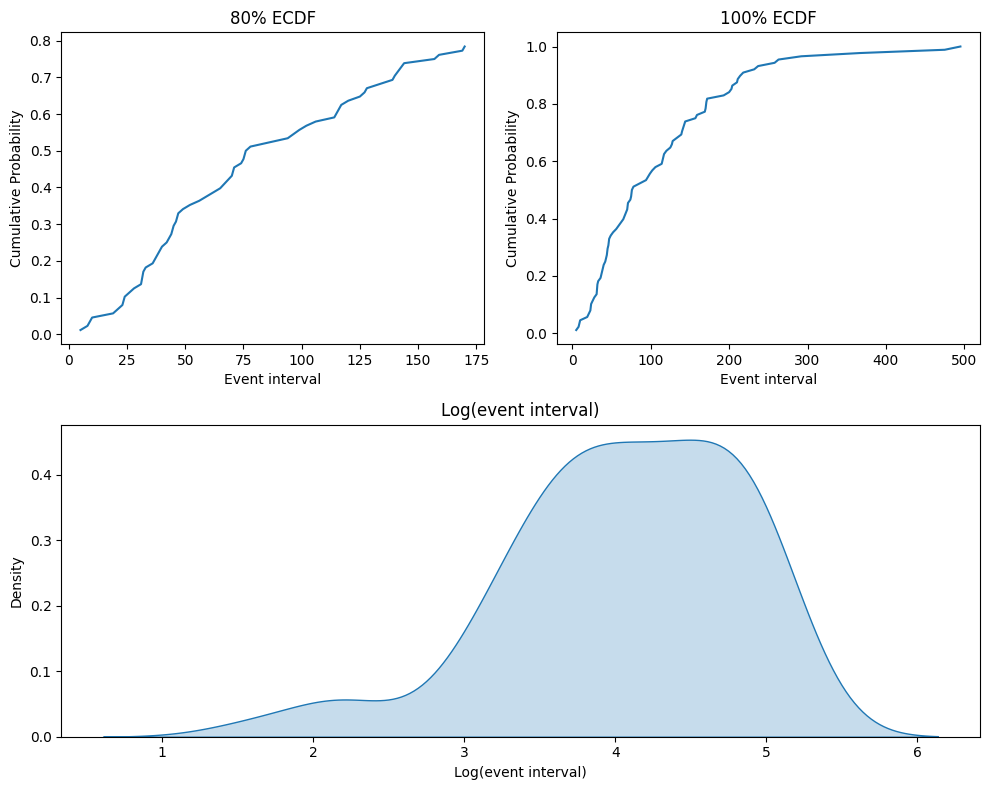

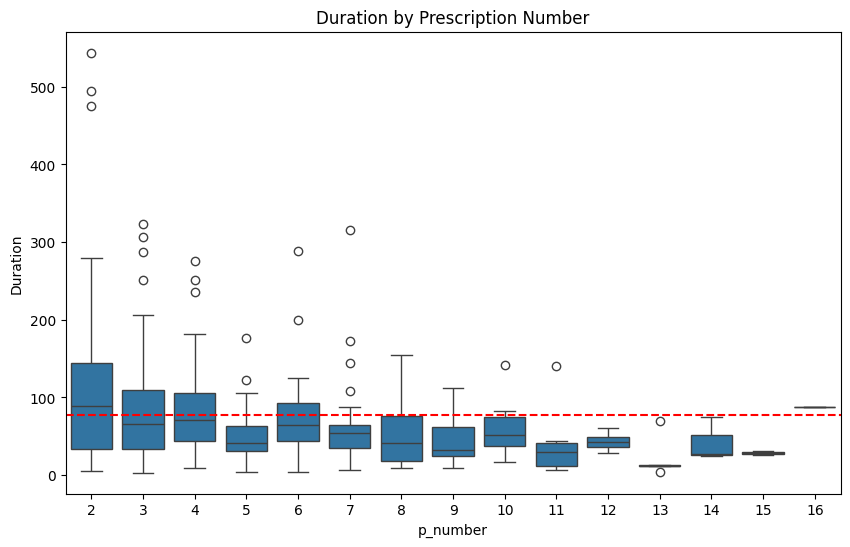

In [ ]:
med_a_kmeans = SEE_KMeans("medA")

SEE_assumption(med_a_kmeans)

#### B. ATC = medB

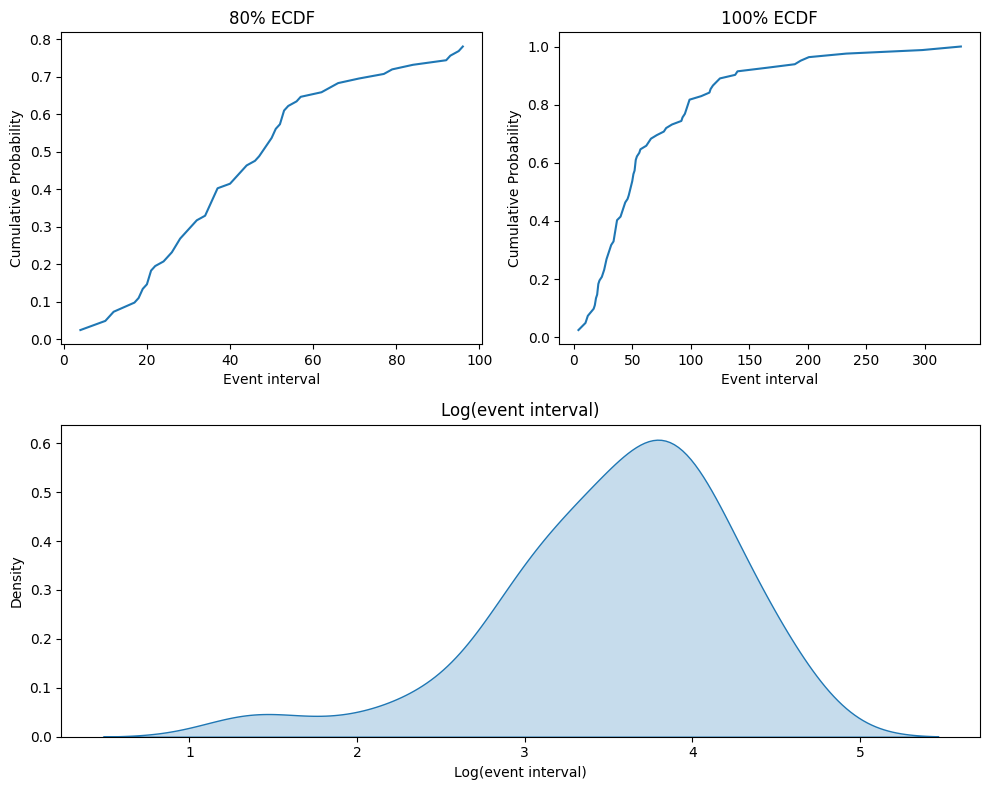

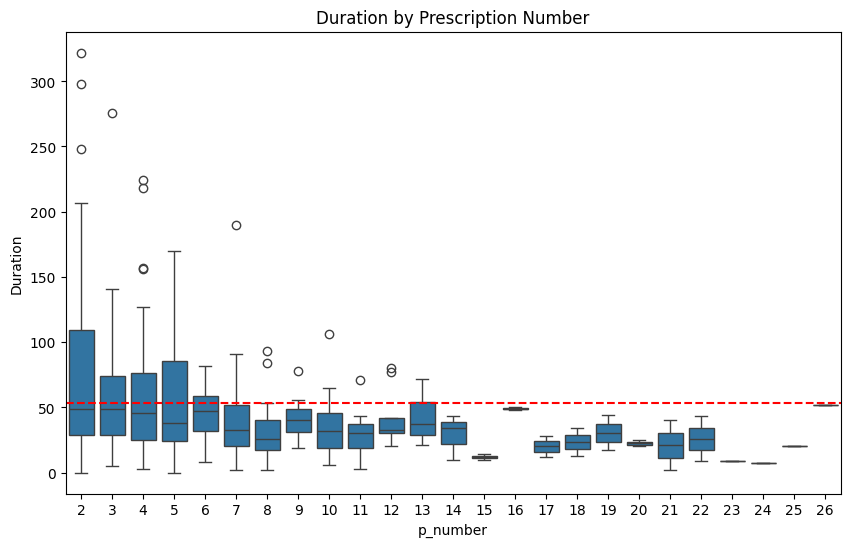

In [ ]:
med_b_kmeans = SEE_KMeans("medB")

SEE_assumption(med_b_kmeans)

#### *Sessa Empirical Estimator using DBSCAN*

#### A. ATC = medA

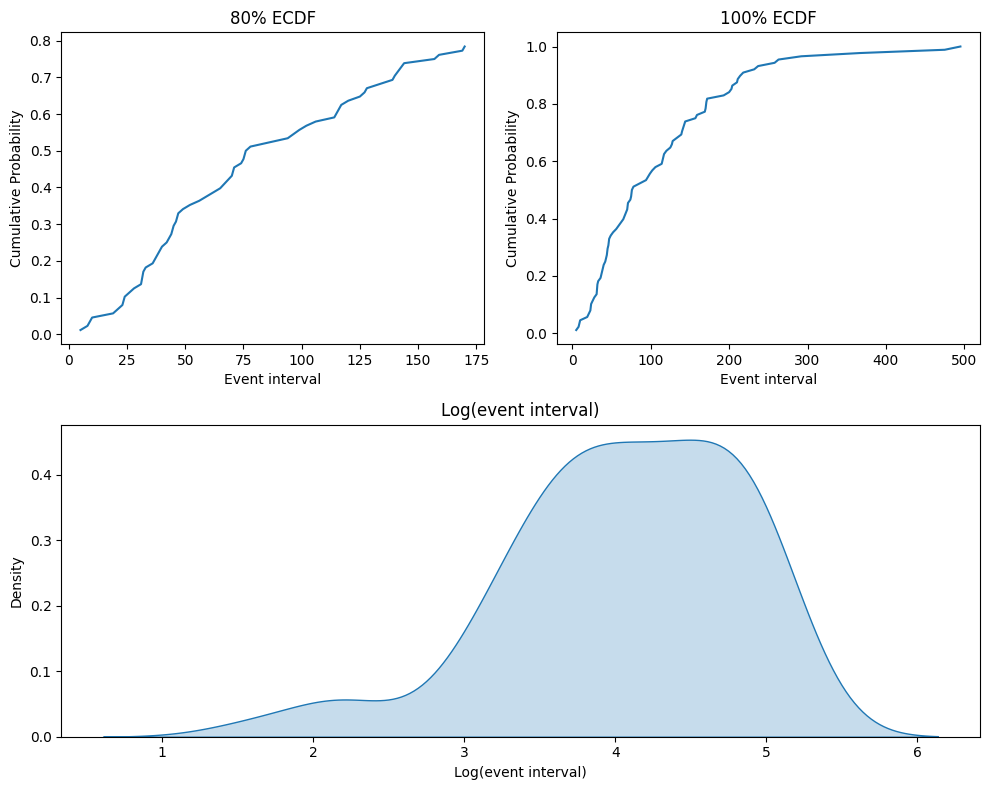

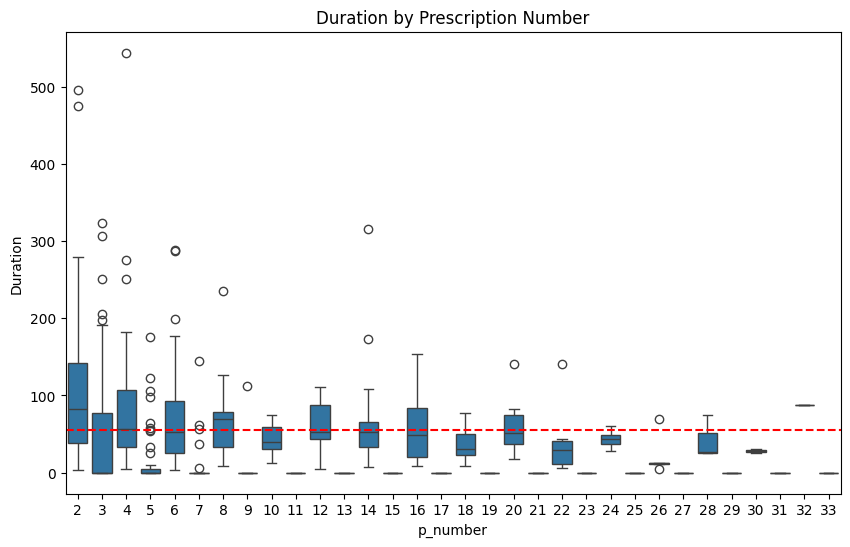

In [ ]:
med_a_dbscan = SEE_DBSCAN("medA")

SEE_assumption(med_a_dbscan)

#### B. ATC = medB

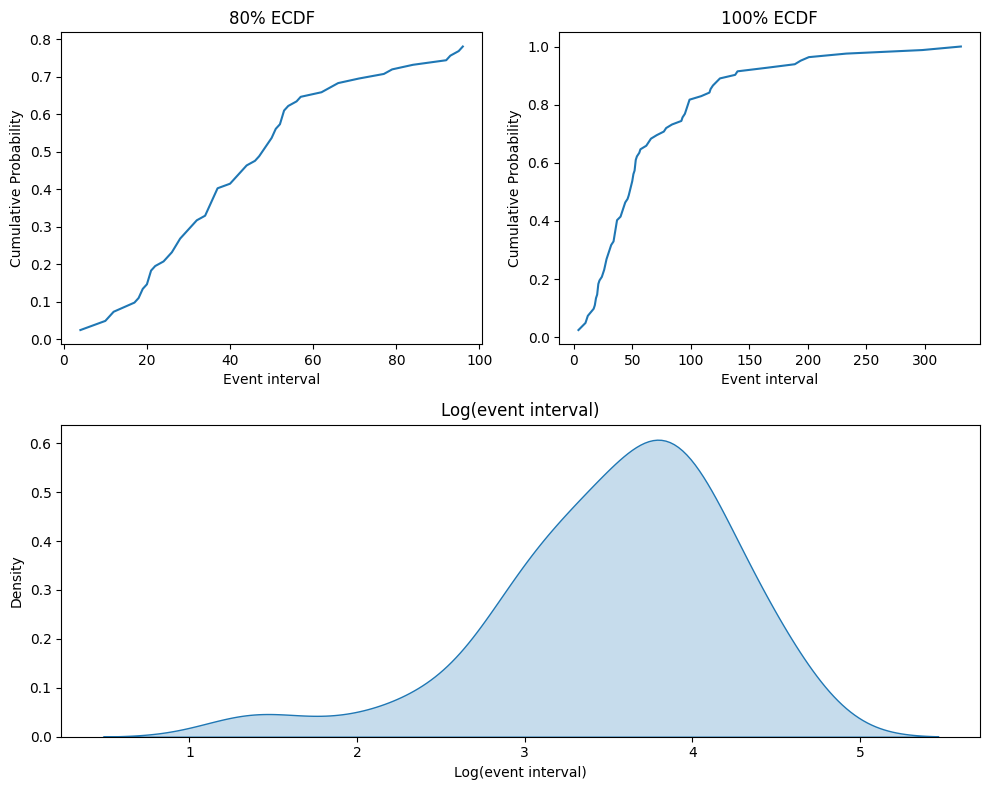

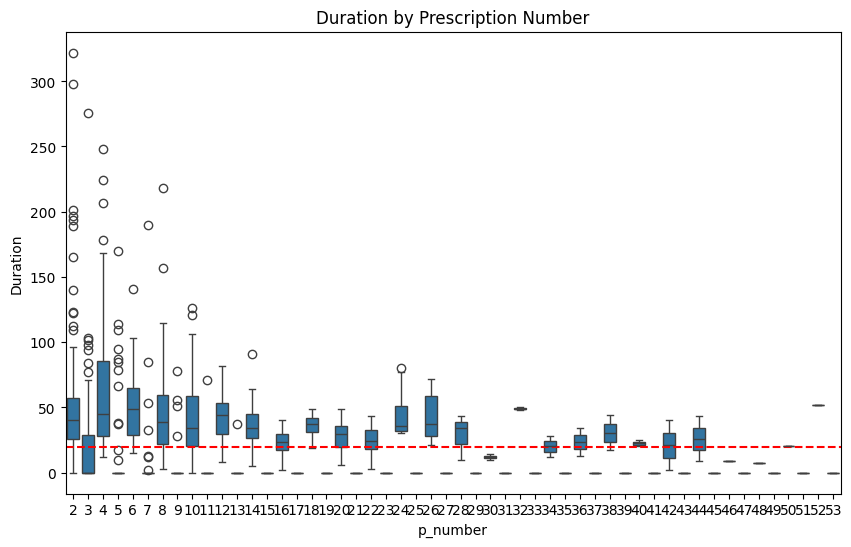

In [ ]:
med_b_dbscan = SEE_DBSCAN("medB")

SEE_assumption(med_b_dbscan)

#### *Comparison of Clustering Methods*

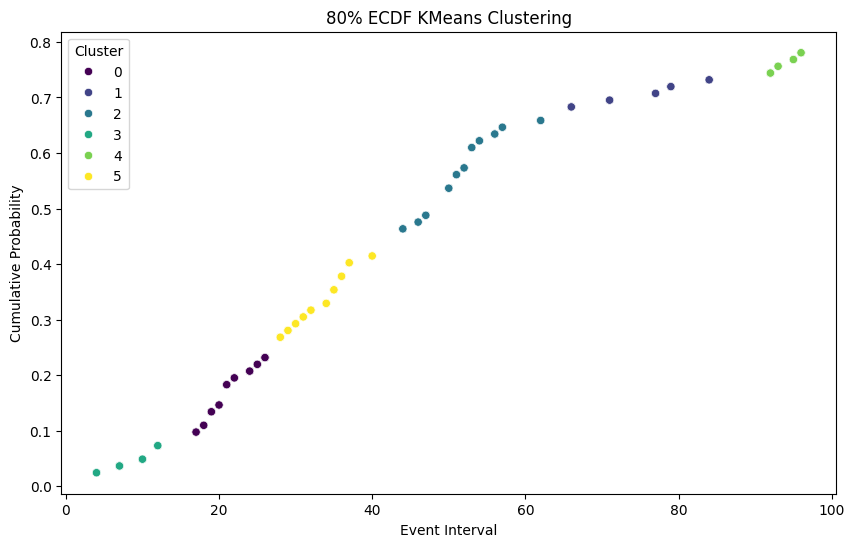

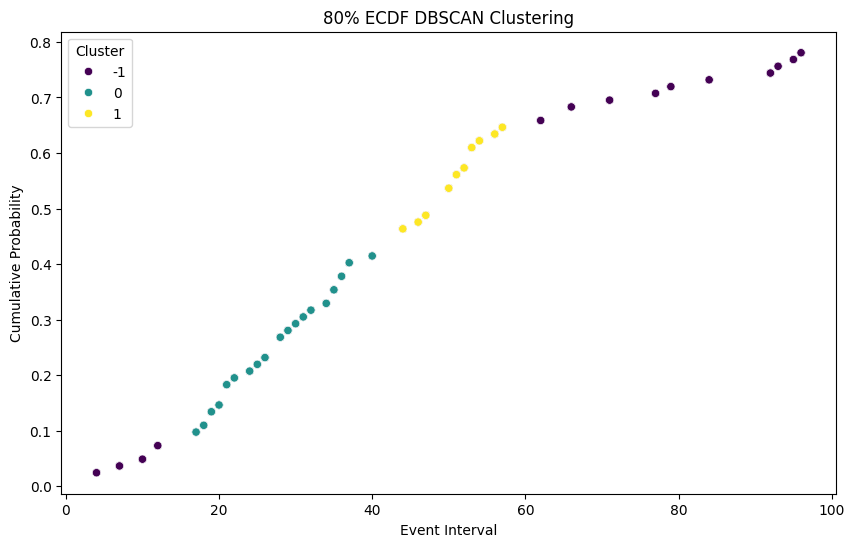

In [ ]:
SEE_clustering_plot(med_b_kmeans, "KMeans")
SEE_clustering_plot(med_b_dbscan, "DBSCAN")